<a href="https://colab.research.google.com/github/chouhandiksha/bigdataproject/blob/colab/sketch/justin/SPARK_LA_CENSUS_Population_Density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load and display json map of chicago with d3
# Load population and cbg area
# Calculate density
# Draw density on the map

# Load social distancing Stay at home
# Display on map

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install geopandas

     |████████████████████████████████| 1.0MB 17.1MB/s 
     |████████████████████████████████| 15.3MB 388kB/s 
     |████████████████████████████████| 6.5MB 44.8MB/s 


In [4]:
import os
from tqdm.notebook import tqdm, trange

# Import modules
import geopandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

from IPython.display import display, HTML
import json

import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [5]:
# LA Counties
fips = ['06037','06059']
f_string = " ( '06037','06059' ) "


city_dir = 'la'

source = Path('drive/MyDrive/big-data-project/data/unprocessed/census/safegraph_open_census_data/')
target = Path('drive/MyDrive/big-data-project/data/clean-data/')

**Spark SQL Documentation:** 
https://spark.apache.org/docs/2.2.0/sql-programming-guide.html

In [6]:
# Install required dependancies
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 212.3MB 69kB/s 
     |████████████████████████████████| 204kB 19.7MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=6a267b1e19bee159ff5ef9cee6424dc23260d6b58d2bcf810ec7a68b9ca5b629
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

In [7]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [8]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [9]:
!ls drive/MyDrive/big-data-project/data/unprocessed/census/safegraph_open_census_data/data/

cbg_b00.csv  cbg_b08.csv  cbg_b15.csv  cbg_b23.csv  cbg_c17.csv
cbg_b01.csv  cbg_b09.csv  cbg_b19.csv  cbg_b25.csv  cbg_c24.csv
cbg_b02.csv  cbg_b11.csv  cbg_b20.csv  cbg_b27.csv  cbg_patterns.csv
cbg_b03.csv  cbg_b12.csv  cbg_b21.csv  cbg_b99.csv
cbg_b07.csv  cbg_b14.csv  cbg_b22.csv  cbg_c16.csv


In [10]:
filepath = source/'metadata/cbg_geographic_data.csv'
df_meta = spark.read.format('csv').option('header','true').option('quote',"\"").option('escape',"\"").load(str(filepath))
df_meta.show()

+------------------+-----------+------------+----------+-----------+
|census_block_group|amount_land|amount_water|  latitude|  longitude|
+------------------+-----------+------------+----------+-----------+
|      010010201001|    4254524|       23431|32.4658291|-86.4896143|
|      010010201002|    5568295|           0|32.4858487|-86.4896898|
|      010010202001|    2058380|           0|32.4800823|-86.4749744|
|      010010202002|    1283506|        5968| 32.464435|-86.4697659|
|      010010203001|    3866515|        9054| 32.480175|-86.4607925|
|      010010203002|    1482758|           0|32.4643093|-86.4584716|
|      010010204001|    2730062|        1011|32.4851607|-86.4447716|
|      010010204002|    1782462|       15233|32.4704377|-86.4359688|
|      010010204003|     750824|           0|32.4632218|-86.4442795|
|      010010204004|    1119359|           0|32.4560697|-86.4417625|
|      010010205001|    4317356|           0|32.4460719| -86.418657|
|      010010205002|    5196333|  

In [11]:
df_meta.createOrReplaceTempView('T')
df_meta = spark.sql('SELECT * FROM T WHERE SUBSTRING(`census_block_group`,1,5) IN ' + f_string)
df_meta.show()

+------------------+-----------+------------+----------+------------+
|census_block_group|amount_land|amount_water|  latitude|   longitude|
+------------------+-----------+------------+----------+------------+
|      060371011101|     447306|           0|34.2593593|-118.2881296|
|      060371011102|     354405|           0|34.2578108|-118.2960924|
|      060371011103|     340691|           0|34.2613533|-118.2961338|
|      060371011221|    1590035|           0|34.2709456|-118.2946904|
|      060371011222|    1054009|           0| 34.262857|-118.2832924|
|      060371012101|     296512|           0|34.2513519|-118.2885261|
|      060371012102|     354178|           0| 34.254329|-118.2925767|
|      060371012201|     332117|           0|34.2537861|-118.2817171|
|      060371012202|     366769|           0|34.2496362|-118.2815564|
|      060371013001|    1380524|           0| 34.253796|-118.2707965|
|      060371013002|     627773|           0|34.2386337|-118.2701321|
|      060371013003|

In [12]:
df_meta = df_meta.toPandas()
df_meta = df_meta.rename(columns={'census_block_group':'cbg'})
df_meta

,cbg,amount_land,amount_water,latitude,longitude
0,060371011101,447306,0,34.2593593,-118.2881296
1,060371011102,354405,0,34.2578108,-118.2960924
2,060371011103,340691,0,34.2613533,-118.2961338
3,060371011221,1590035,0,34.2709456,-118.2946904
4,060371011222,1054009,0,34.262857,-118.2832924
...,...,...,...,...,...
8243,060591106071,395022,0,33.8845643,-117.9997377
8244,060591106072,487075,0,33.8756198,-117.9930725
8245,060591106073,376918,0,33.8797696,-117.9934015
8246,060599800001,2766486,0,33.8096249,-117.9186718


In [13]:
filepath = source/'data/cbg_b01.csv'
df_pop = spark.read.format('csv').option('header','true').option('quote',"\"").option('escape',"\"").load(str(filepath))
df_pop.show()

+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------+--------+

In [14]:
df_pop.createOrReplaceTempView('T')
df_pop = spark.sql('SELECT * FROM T WHERE SUBSTRING(`census_block_group`,1,5) IN ' + f_string)
df_pop.show()

+------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------+--------+

In [15]:
df_pop = df_pop.toPandas()
df_pop = df_pop[['census_block_group','B01003e1']]
df_pop = df_pop.rename(columns={'census_block_group':'cbg', 'B01003e1':'pop_total'})
df_pop

,cbg,pop_total
0,060371011101,1785
1,060371011102,1770
2,060371011103,1112
3,060371011221,2169
4,060371011222,1132
...,...,...
8243,060591106071,789
8244,060591106072,1700
8245,060591106073,1744
8246,060599800001,25


In [16]:
df_merge = df_pop.merge(df_meta, how='inner', on='cbg')
df_merge

,cbg,pop_total,amount_land,amount_water,latitude,longitude
0,060371011101,1785,447306,0,34.2593593,-118.2881296
1,060371011102,1770,354405,0,34.2578108,-118.2960924
2,060371011103,1112,340691,0,34.2613533,-118.2961338
3,060371011221,2169,1590035,0,34.2709456,-118.2946904
4,060371011222,1132,1054009,0,34.262857,-118.2832924
...,...,...,...,...,...,...
8243,060591106071,789,395022,0,33.8845643,-117.9997377
8244,060591106072,1700,487075,0,33.8756198,-117.9930725
8245,060591106073,1744,376918,0,33.8797696,-117.9934015
8246,060599800001,25,2766486,0,33.8096249,-117.9186718


In [17]:
df_merge['person_per_sq_meter'] = np.where((df_merge['amount_land'].to_numpy(dtype=np.float32) != 0.0) & (df_merge['pop_total'].to_numpy(dtype=np.float32) != 0.0), 
         df_merge['pop_total'].to_numpy(dtype=np.float32) / df_merge['amount_land'].to_numpy(dtype=np.float32),
         0.0)
df_merge.sort_values(by='person_per_sq_meter')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


,cbg,pop_total,amount_land,amount_water,latitude,longitude,person_per_sq_meter
8247,060599901000,0,0,352603583,33.5333068,-117.8559677,0.000000
6400,060379800051,0,3957818,95526,33.8534589,-118.3273387,0.000000
6399,060379800041,0,44628278,590534,34.6195735,-118.0923551,0.000000
4482,060375409024,0,1224923,1031,33.9113014,-118.2760665,0.000000
6397,060379800021,0,6773682,208608,33.8104081,-118.2386708,0.000000
...,...,...,...,...,...,...,...
1340,060372089041,2140,53914,0,34.0592371,-118.2694722,0.039693
1410,060372119221,1791,44683,0,34.0681625,-118.2954259,0.040082
1338,060372089031,2422,55480,0,34.0604432,-118.2719215,0.043655
1333,060372088012,1258,28013,0,34.0617348,-118.2767572,0.044908


In [18]:
df_merge = df_merge.set_index('cbg')
df_merge

,pop_total,amount_land,amount_water,latitude,longitude,person_per_sq_meter
cbg,,,,,,
060371011101,1785,447306,0,34.2593593,-118.2881296,0.003991
060371011102,1770,354405,0,34.2578108,-118.2960924,0.004994
060371011103,1112,340691,0,34.2613533,-118.2961338,0.003264
060371011221,2169,1590035,0,34.2709456,-118.2946904,0.001364
060371011222,1132,1054009,0,34.262857,-118.2832924,0.001074
...,...,...,...,...,...,...
060591106071,789,395022,0,33.8845643,-117.9997377,0.001997
060591106072,1700,487075,0,33.8756198,-117.9930725,0.003490
060591106073,1744,376918,0,33.8797696,-117.9934015,0.004627


In [19]:
!ls drive/MyDrive/big-data-project/data/clean-data/ch/ch.geojson

drive/MyDrive/big-data-project/data/clean-data/ch/ch.geojson


In [32]:
# Read geojson file
gdf = geopandas.read_file('drive/MyDrive/big-data-project/data/clean-data/{}/{}.geojson'.format(city_dir,city_dir))
gdf

,StateFIPS,CountyFIPS,TractCode,BlockGroup,CensusBlockGroup,State,County,ClassCode,geometry
0,06,037,310400,3,060373104003,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.35037 34.20667, -118.3499..."
1,06,059,086502,3,060590865023,CA,Orange County,H1,"MULTIPOLYGON (((-117.91372 33.84724, -117.9135..."
2,06,037,651002,4,060376510024,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.32800 33.80984, -118.3277..."
3,06,037,651101,1,060376511011,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.34007 33.82307, -118.3400..."
4,06,059,099402,3,060590994023,CA,Orange County,H1,"MULTIPOLYGON (((-118.00659 33.71548, -118.0052..."
...,...,...,...,...,...,...,...,...,...
8243,06,037,603302,1,060376033021,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.30479 33.88014, -118.3043..."
8244,06,037,603302,2,060376033022,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.30914 33.88013, -118.3086..."
8245,06,037,603302,3,060376033023,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.31349 33.88049, -118.3134..."
8246,06,037,603400,1,060376034001,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.31348 33.89941, -118.3134..."


In [33]:
# simplify column name
gdf = gdf.rename(columns={'CensusBlockGroup':'cbg'})
gdf

,StateFIPS,CountyFIPS,TractCode,BlockGroup,cbg,State,County,ClassCode,geometry
0,06,037,310400,3,060373104003,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.35037 34.20667, -118.3499..."
1,06,059,086502,3,060590865023,CA,Orange County,H1,"MULTIPOLYGON (((-117.91372 33.84724, -117.9135..."
2,06,037,651002,4,060376510024,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.32800 33.80984, -118.3277..."
3,06,037,651101,1,060376511011,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.34007 33.82307, -118.3400..."
4,06,059,099402,3,060590994023,CA,Orange County,H1,"MULTIPOLYGON (((-118.00659 33.71548, -118.0052..."
...,...,...,...,...,...,...,...,...,...
8243,06,037,603302,1,060376033021,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.30479 33.88014, -118.3043..."
8244,06,037,603302,2,060376033022,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.30914 33.88013, -118.3086..."
8245,06,037,603302,3,060376033023,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.31349 33.88049, -118.3134..."
8246,06,037,603400,1,060376034001,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.31348 33.89941, -118.3134..."


In [34]:
# set index for join
gdf = gdf.set_index('cbg')
gdf

,StateFIPS,CountyFIPS,TractCode,BlockGroup,State,County,ClassCode,geometry
cbg,,,,,,,,
060373104003,06,037,310400,3,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.35037 34.20667, -118.3499..."
060590865023,06,059,086502,3,CA,Orange County,H1,"MULTIPOLYGON (((-117.91372 33.84724, -117.9135..."
060376510024,06,037,651002,4,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.32800 33.80984, -118.3277..."
060376511011,06,037,651101,1,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.34007 33.82307, -118.3400..."
060590994023,06,059,099402,3,CA,Orange County,H1,"MULTIPOLYGON (((-118.00659 33.71548, -118.0052..."
...,...,...,...,...,...,...,...,...
060376033021,06,037,603302,1,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.30479 33.88014, -118.3043..."
060376033022,06,037,603302,2,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.30914 33.88013, -118.3086..."
060376033023,06,037,603302,3,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.31349 33.88049, -118.3134..."


In [35]:
gdf = gdf.merge(df_merge, left_index=True, right_index=True)
gdf

,StateFIPS,CountyFIPS,TractCode,BlockGroup,State,County,ClassCode,geometry,pop_total,amount_land,amount_water,latitude,longitude,person_per_sq_meter
cbg,,,,,,,,,,,,,,
060373104003,06,037,310400,3,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.35037 34.20667, -118.3499...",1286,764102,0,34.2035192,-118.3401897,0.001683
060590865023,06,059,086502,3,CA,Orange County,H1,"MULTIPOLYGON (((-117.91372 33.84724, -117.9135...",2545,290933,0,33.8454718,-117.9094315,0.008748
060376510024,06,037,651002,4,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.32800 33.80984, -118.3277...",1285,246669,0,33.8083636,-118.3239442,0.005209
060376511011,06,037,651101,1,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.34007 33.82307, -118.3400...",2708,871365,0,33.8183814,-118.3326885,0.003108
060590994023,06,059,099402,3,CA,Orange County,H1,"MULTIPOLYGON (((-118.00659 33.71548, -118.0052...",672,1299934,0,33.7082565,-118.0021699,0.000517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
060376033021,06,037,603302,1,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.30479 33.88014, -118.3043...",1098,187317,0,33.8783144,-118.3022616,0.005862
060376033022,06,037,603302,2,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.30914 33.88013, -118.3086...",2053,546315,0,33.875751,-118.3049125,0.003758
060376033023,06,037,603302,3,CA,Los Angeles County,H1,"MULTIPOLYGON (((-118.31349 33.88049, -118.3134...",955,390896,10554,33.8778485,-118.3111783,0.002443


In [36]:
maxs = gdf['person_per_sq_meter'].max()
mins = gdf['person_per_sq_meter'].min()
print(maxs)
print(mins)

0.046805668622255325
0.0


In [37]:
gdf['person_per_sq_meter_sqrt'] = np.sqrt(gdf['person_per_sq_meter'])

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

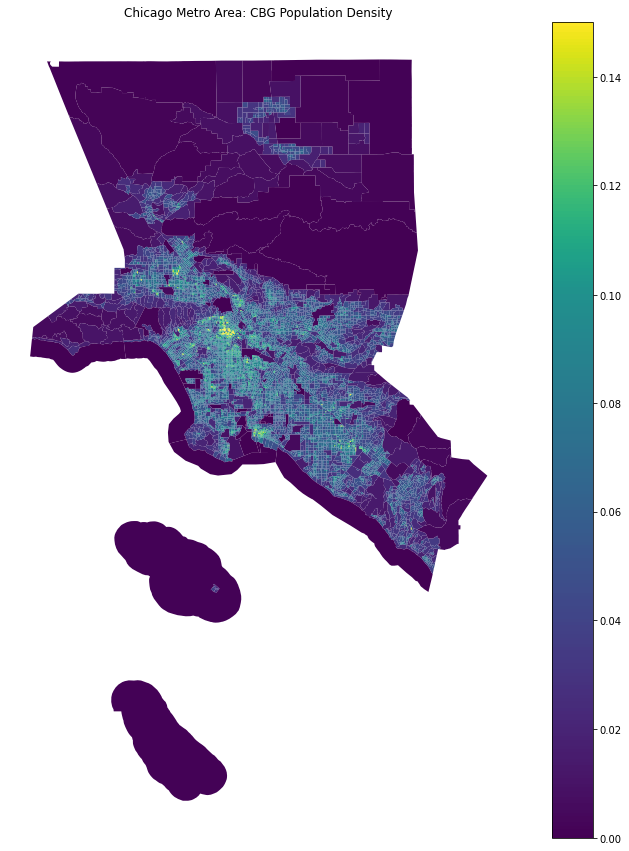

In [39]:
import matplotlib
# Plot density

# fig, ax = plt.subplots()
midnorm = MidpointNormalize(vmin=0., vcenter=0.1, vmax=0.15)

fig, ax = plt.subplots(figsize = (15,15))
ax.title.set_text('Chicago Metro Area: CBG Population Density')
ax.axis('off')
# gdf.plot(column='person_per_sq_meter', ax=ax, legend=True);
gdf.plot(column='person_per_sq_meter_sqrt', ax=ax, legend=True, norm=midnorm);

In [40]:
!pip install geoplot



In [41]:
import geoplot as gplt

import geoplot.crs as gcrs

In [42]:
!ls drive/MyDrive/big-data-project/sketch/justin/

ch.geojson		    la-time
ch_social_summary_2019.csv  movies
ch-time			    ny.geojson
ch_time_data.csv	    ny_social_summary_2019.csv
ch_time.geojson		    ny-time
la_social_summary_2019.csv


In [43]:
gdf.to_file("drive/MyDrive/big-data-project/sketch/justin/{}.geojson".format(city_dir), driver='GeoJSON')

In [ ]:
# pip install keplergl